**自适应精细积分法**

In [4]:
%reset -f

In [5]:
%matplotlib inline
import sys, os
sys.path.append(os.path.dirname(os.path.realpath('../utils')))
import numpy as np
from matplotlib import pyplot as plt
from utils.aiwt import cjkfun, z_g, CompressInterp, adapt_CjJ4
from utils.pde import theta1_2d


In [6]:
j0 = 0
J = 15
a = 0
b = 2
deltax = (b-a)/(2**J)
XJ0 = np.arange(a, b+deltax, deltax).reshape(1,-1)
V0 = np.sin(np.pi * XJ0)
window = 3
eps0 = 0.005

M = 1
CC = 1

cjk, cjknum, zJc, zJcnum = cjkfun(V0, J, j0, a, b, eps0)
gjk, gjknum, gJc, gJcnum = z_g(j0, J, cjk, cjknum, zJc, zJcnum, a, b, M, CC)
XJ = a + deltax * gJc
V0 = CompressInterp(XJ0,V0,XJ)

In [7]:
C = adapt_CjJ4(J, j0, gjk, gjknum, gJc, gJcnum, a, b)

In [8]:
theta1d, theta2d = theta1_2d(J, j0, a, b, C, gjk, gjknum, gJc, gJcnum)

In [9]:
Re = 1000
tao = 0.001

In [10]:
def Vd(Vk,Re,theta1d,theta2d):
    V = Vk.reshape((-1,1))
    s1 = np.dot(theta2d, V)
    s2 = np.dot(theta1d, V)
    Vd1 = s1 / Re - V * s2
    return Vd1

In [11]:
def M012(Vk,Re,theta1d,theta2d):
    Vk = Vk.reshape((-1,1))
    Vd1 = Vd (Vk,Re,theta1d,theta2d)
    M00 = theta2d / Re
    Vkdiag = np.diag(Vk.reshape(-1))
    M11 = -np.dot(Vkdiag, theta1d)
    Vd1diag = np.diag(Vd1.reshape(-1))
    M22 = np.dot(theta1d, Vd1diag)
    return M00, M11, M22

In [12]:
def Precise(V0,Re,theta1d,theta2d,gJcnum,tao):
    V0 = V0.reshape((-1, 1))
    N = 10
    m = 2 ** N
    deltat = tao / m
    M00, M11, M22 = M012(V0,Re,theta1d,theta2d)
    r0 = np.dot(M11, V0)
    r1 = np.dot(M22, V0) + np.dot(M11, np.dot((M00 + M11), V0))
    I = np.eye(gJcnum, gJcnum)
    deltatH = deltat * M00
    deltatH2 = np.dot(deltatH, deltatH)
    Ta = deltatH + np.dot(deltatH2, (I + deltatH / 3 + deltatH2 / 12)) / 2
    for _ in range(N):
        Ta = 2 * Ta + np.dot(Ta, Ta)
    T = I + Ta
    invM00 = np.linalg.inv(M00)
    temp = r0 + np.dot(invM00, r1)
    V1 = np.dot(T, (V0 + np.dot(invM00, temp))) - np.dot(invM00, (temp + tao * r1))
    return V1

In [13]:
V1 = Precise(V0,Re,theta1d,theta2d,gJcnum,tao)

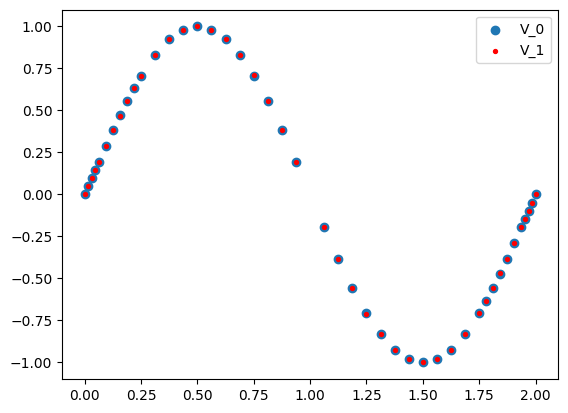

In [24]:
plt.scatter(XJ, V0[:,0],label='V_0')
plt.scatter(XJ, V1[:,0], s=8, c='r', label='V_1')
plt.legend()